# On Deep Learning-Based Channel Decoding

If you want to cite this notebook, please use the following bibtext entry:

    @article{nn-decoding,
      title={On Deep Learning-Based Channel Decoding},
      author={Tobias Gruber and
              Sebastian Cammerer and
              Jakob Hoydis and
              Stephan ten Brink}
      journal={CoRR}
      year={2017}
      url= {http://arxiv.org/abs/1701.07738}
    }

Running this example requires Keras installed with the Theano backend. For GPU support nvidia-docker is required. A Dockerfile is provided to employ this setup quickly.

Our simulation setup was inspired by material from http://radioml.org.


In [1]:
from os import environ
environ['KERAS_BACKEND']='tensorflow'

In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Lambda
from keras import backend as K
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import datetime
import timeit
import pandas as pd
%matplotlib inline
print(K.backend())

Using TensorFlow backend.


tensorflow


In [3]:
import tensorflow as tf
print(tf.test.is_gpu_available(cuda_only=True))
from tensorflow.python.client import device_lib
print(str(device_lib.list_local_devices()))

True
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9335751599726563625
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3173977294
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14665906624801336323
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 960, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


# Parameters

In [4]:
k = 8                       # number of information bits
N = 16                      # code length
train_SNR_Eb = 1            # training-Eb/No

nb_epoch = 2**14            # number of learning epochs
code = 'random'             # type of code ('random' or 'polar')
design = [256, 128, 64]     # each list entry defines the number of nodes in a layer
batch_size = 256            # size of batches for calculation the gradient
LLR = False                 # 'True' enables the log-likelihood-ratio layer
optimizer = 'adam'           
loss = 'mse'                # or 'binary_crossentropy'

train_SNR_Es = train_SNR_Eb + 10*np.log10(k/N)
train_sigma = np.sqrt(1/(2*10**(train_SNR_Es/10)))

# Define NN model

In [5]:
def modulateBPSK(x):
    return -2*x +1;

def addNoise(x, sigma):
    w = K.random_normal(K.shape(x), mean=0.0, stddev=sigma)
    return x + w

def ber(y_true, y_pred):
    return K.mean(K.not_equal(y_true, K.round(y_pred)))

def return_output_shape(input_shape):  
    return input_shape

def compose_model(layers):
    model = Sequential()
    for layer in layers:
        model.add(layer)
    return model

def log_likelihood_ratio(x, sigma):
    return 2*x/np.float32(sigma**2)

# https://pt.coredump.biz/questions/45328314/kerastensorflow-adding-a-new-metric-with-an-inequality
def errors(y_true, y_pred):
    return K.sum(K.cast(K.not_equal(y_true, K.round(y_pred)),'float32'))

In [6]:
# Define modulator
modulator_layers = [Lambda(modulateBPSK, 
                          input_shape=(N,), output_shape=return_output_shape, name="modulator")]
modulator = compose_model(modulator_layers)
modulator.compile(optimizer=optimizer, loss=loss)

# Define noise
noise_layers = [Lambda(addNoise, arguments={'sigma':train_sigma}, 
                       input_shape=(N,), output_shape=return_output_shape, name="noise")]
noise = compose_model(noise_layers)
noise.compile(optimizer=optimizer, loss=loss)

# Define LLR
llr_layers = [Lambda(log_likelihood_ratio, arguments={'sigma':train_sigma}, 
                     input_shape=(N,), output_shape=return_output_shape, name="LLR")]
llr = compose_model(llr_layers)
llr.compile(optimizer=optimizer, loss=loss)

# Define decoder 
decoder_layers = [Dense(design[0], activation='relu', input_shape=(N,))]
for i in range(1,len(design)):
    decoder_layers.append(Dense(design[i], activation='relu'))
decoder_layers.append(Dense(k, activation='sigmoid'))
decoder = compose_model(decoder_layers)
decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])

# Define model
if LLR:
    model_layers = modulator_layers + noise_layers + llr_layers + decoder_layers
else:
    model_layers = modulator_layers + noise_layers + decoder_layers
model = compose_model(model_layers)
model.compile(optimizer=optimizer, loss=loss, metrics=[ber])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# Data Generation

In [7]:
def half_adder(a,b):
    s = a ^ b
    c = a & b
    return s,c

def full_adder(a,b,c):
    s = (a ^ b) ^ c
    c = (a & b) | (c & (a ^ b))
    return s,c

def add_bool(a,b):
    if len(a) != len(b):
        raise ValueError('arrays with different length')
    k = len(a)
    s = np.zeros(k,dtype=bool)
    c = False
    for i in reversed(range(0,k)):
        s[i], c = full_adder(a[i],b[i],c)    
    if c:
        warnings.warn("Addition overflow!")
    return s

def inc_bool(a):
    k = len(a)
    increment = np.hstack((np.zeros(k-1,dtype=bool), np.ones(1,dtype=bool)))
    a = add_bool(a,increment)
    return a

def bitrevorder(x):
    m = np.amax(x)
    n = np.ceil(np.log2(m)).astype(int)
    for i in range(0,len(x)):
        x[i] = int('{:0{n}b}'.format(x[i],n=n)[::-1],2)  
    return x

def int2bin(x,N):
    if isinstance(x, list) or isinstance(x, np.ndarray):
        binary = np.zeros((len(x),N),dtype='bool')
        for i in range(0,len(x)):
            binary[i] = np.array([int(j) for j in bin(x[i])[2:].zfill(N)])
    else:
        binary = np.array([int(j) for j in bin(x)[2:].zfill(N)],dtype=bool)
    
    return binary

def bin2int(b):
    if isinstance(b[0], list):
        integer = np.zeros((len(b),),dtype=int)
        for i in range(0,len(b)):
            out = 0
            for bit in b[i]:
                out = (out << 1) | bit
            integer[i] = out
    elif isinstance(b, np.ndarray):
        if len(b.shape) == 1:
            out = 0
            for bit in b:
                out = (out << 1) | bit
            integer = out     
        else:
            integer = np.zeros((b.shape[0],),dtype=int)
            for i in range(0,b.shape[0]):
                out = 0
                for bit in b[i]:
                    out = (out << 1) | bit
                integer[i] = out
        
    return integer

def polar_design_awgn(N, k, design_snr_dB):  
        
    S = 10**(design_snr_dB/10)
    z0 = np.zeros(N)

    z0[0] = np.exp(-S)
    for j in range(1,int(np.log2(N))+1):
        u = 2**j
        for t in range(0,int(u/2)):
            T = z0[t]
            z0[t] = 2*T - T**2     # upper channel
            z0[int(u/2)+t] = T**2  # lower channel
        
    # sort into increasing order
    idx = np.argsort(z0)
        
    # select k best channels
    idx = np.sort(bitrevorder(idx[0:k]))
    
    A = np.zeros(N, dtype=bool)
    A[idx] = True
        
    return A

def polar_transform_iter(u):

    N = len(u)
    n = 1
    x = np.copy(u)
    stages = np.log2(N).astype(int)
    for s in range(0,stages):
        i = 0
        while i < N:
            for j in range(0,n):
                idx = i+j
                x[idx] = x[idx] ^ x[idx+n]
            i=i+2*n
        n=2*n
    return x

In [8]:
# Create all possible information words
d = np.zeros((2**k,k),dtype=bool)
for i in range(1,2**k):
    d[i]= inc_bool(d[i-1])

# Create sets of all possible codewords (codebook)
if code == 'polar':   
    
    A = polar_design_awgn(N, k, design_snr_dB=0)  # logical vector indicating the nonfrozen bit locations 
    x = np.zeros((2**k, N),dtype=bool)
    u = np.zeros((2**k, N),dtype=bool)
    u[:,A] = d

    for i in range(0,2**k):
        x[i] = polar_transform_iter(u[i])

elif code == 'random':
    
    np.random.seed(4267)   # for a 16bit Random Code (r=0.5) with Hamming distance >= 2
    x = np.random.randint(0,2,size=(2**k,N), dtype=bool)
    
print(f'd[0] = {d[0]}\tnp.shape(d) = {np.shape(d)}')
print(f'x[0] = {x[0]}\tnp.shape(x) = {np.shape(x)}')

d[0] = [False False False False False False False False]	np.shape(d) = (256, 8)
x[0] = [ True False  True False False  True  True  True False  True  True False
 False False  True  True]	np.shape(x) = (256, 16)


In [9]:
xf = x.astype('float32')
def decode_map(y):
    min_dist = +1e+16
    max_dist = -1e+16
    for cand in xf:
        dist = np.linalg.norm(x-y)
        if dist < min_dist:
            min_dist = dist
        if dist > max_dist:
            max_dist = dist
    print(f'min_dist={min_dist}\tmax_dist={max_dist}')

# Train Neural Network

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
modulator (Lambda)           (None, 16)                0         
_________________________________________________________________
noise (Lambda)               (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4352      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 520       
Total params: 46,024
Trainable params: 46,024
Non-trainable params: 0
__________________________________________________

	2021-06-15 17:47:20.708555	i=12	sigma=0.7235839948570626	nb_bits=800000	nb_errors=60700
	2021-06-15 17:47:21.641557	i=13	sigma=0.7005493277618178	nb_bits=800000	nb_errors=54100
	2021-06-15 17:47:22.677555	i=14	sigma=0.677514660666573	nb_bits=800000	nb_errors=46700
	2021-06-15 17:47:23.591085	i=15	sigma=0.6544799935713281	nb_bits=800000	nb_errors=39100
	2021-06-15 17:47:24.467521	i=16	sigma=0.6314453264760834	nb_bits=800000	nb_errors=33500
	2021-06-15 17:47:25.333440	i=17	sigma=0.6084106593808387	nb_bits=800000	nb_errors=27900
	2021-06-15 17:47:26.216070	i=18	sigma=0.5853759922855939	nb_bits=800000	nb_errors=21900
	2021-06-15 17:47:27.085307	i=19	sigma=0.5623413251903491	nb_bits=800000	nb_errors=18000
x_nn = [0.         0.20241693 0.4096638  0.62197673 0.83960963 1.06283596
 1.29195086 1.52727343 1.76914943 2.01795437 2.27409696 2.53802318
 2.81022096 3.09122559 3.38162605 3.68207249 3.99328494 4.31606371
 4.65130186 5.        ]
y_nn = [0.207    0.19625  0.1855   0.17625  0.166875 0.15

nb_epoch=65536	fit finished at 2021-06-15 17:52:47.428580 (took 242.696 [s]).
[1.         0.97696533 0.95393067 0.930896   0.90786133 0.88482666
 0.861792   0.83875733 0.81572266 0.792688   0.76965333 0.74661866
 0.72358399 0.70054933 0.67751466 0.65447999 0.63144533 0.60841066
 0.58537599 0.56234133]
	2021-06-15 17:52:48.273273	i=0	sigma=1.0	nb_bits=800000	nb_errors=128900
	2021-06-15 17:52:49.119020	i=1	sigma=0.9769653329047552	nb_bits=800000	nb_errors=119500
	2021-06-15 17:52:49.961214	i=2	sigma=0.9539306658095105	nb_bits=800000	nb_errors=109200
	2021-06-15 17:52:50.809569	i=3	sigma=0.9308959987142656	nb_bits=800000	nb_errors=101200
	2021-06-15 17:52:51.667513	i=4	sigma=0.9078613316190208	nb_bits=800000	nb_errors=90800
	2021-06-15 17:52:52.512275	i=5	sigma=0.8848266645237761	nb_bits=800000	nb_errors=82200
	2021-06-15 17:52:53.351524	i=6	sigma=0.8617919974285313	nb_bits=800000	nb_errors=72400
	2021-06-15 17:52:54.193960	i=7	sigma=0.8387573303332865	nb_bits=800000	nb_errors=63900
	202

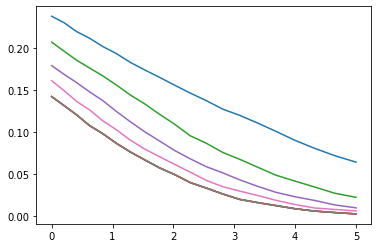

In [10]:
for nb_epoch in [2**10,2**12,2**14,2**16]:
    
    model.summary()

    start_time = timeit.default_timer()
    print(f'nb_epoch={nb_epoch}\tfit started at {datetime.datetime.now()}.')
    history = model.fit(x, d, batch_size=batch_size, epochs=nb_epoch, verbose=0, shuffle=True)
    end_time = timeit.default_timer()
    print(f'nb_epoch={nb_epoch}\tfit finished at {datetime.datetime.now()} (took {end_time-start_time:1.3f} [s]).')

    ###########
    # Test NN #
    ###########
    
    test_batch = 1000  
    num_words = 100000      # multiple of test_batch

    SNR_dB_start_Eb = 0
    SNR_dB_stop_Eb = 5
    SNR_points = 20

    SNR_dB_start_Es = SNR_dB_start_Eb + 10*np.log10(k/N)
    SNR_dB_stop_Es = SNR_dB_stop_Eb + 10*np.log10(k/N)

    sigma_start = np.sqrt(1/(2*10**(SNR_dB_start_Es/10)))
    sigma_stop = np.sqrt(1/(2*10**(SNR_dB_stop_Es/10)))

    sigmas = np.linspace(sigma_start, sigma_stop, SNR_points)
    #print(sigmas)

    nb_errors = np.zeros(len(sigmas),dtype=int)
    nb_bits = np.zeros(len(sigmas),dtype=int)

    for i in range(0,len(sigmas)):

        for ii in range(0,np.round(num_words/test_batch).astype(int)):

            # Source
            np.random.seed(0)
            d_test = np.random.randint(0,2,size=(test_batch,k)) 

            # Encoder
            if code == 'polar':
                x_test = np.zeros((test_batch, N),dtype=bool)
                u_test = np.zeros((test_batch, N),dtype=bool)
                u_test[:,A] = d_test

                for iii in range(0,test_batch):
                    x_test[iii] = polar_transform_iter(u_test[iii])

            elif code == 'random':
                x_test = np.zeros((test_batch, N),dtype=bool)
                for iii in range(0,test_batch):
                    x_test[iii] = x[bin2int(d_test[iii])]

            # Modulator (BPSK)
            s_test = -2*x_test + 1

            # Channel (AWGN)
            y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)
            
            #print('d',np.shape(d_test[0]))
            #print('x',np.shape(x_test[0]))
            #print('s',np.shape(s_test[0]))
            #print('y',np.shape(y_test[0]))
            #print(f'd_test[0]={d_test[0]}\ty_test[0]={y_test[0]}')
            #print(f'dist={decode_map(y_test[0])}')

            if LLR:
                y_test = 2*y_test/(sigmas[i]**2)

            # Decoder
            nb_errors[i] += decoder.evaluate(y_test, d_test, batch_size=test_batch, verbose=0)[1]
            nb_bits[i] += d_test.size
            
        print(f'\t{datetime.datetime.now()}\ti={i}\tsigma={sigmas[i]}\tnb_bits={nb_bits[i]}\tnb_errors={nb_errors[i]}')

    ############
    # Load MAP #
    ############

    result_map = np.loadtxt('map/{}/results_{}_map_{}_{}.txt'.format(code,code,N,k), delimiter=', ')
    sigmas_map = result_map[:,0]
    nb_bits_map = result_map[:,1]
    nb_errors_map = result_map[:,2]

    #######################
    # Plot Bit-Error-Rate #
    #######################

    legend = []

    x_nn = 10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N)
    y_nn = nb_errors/nb_bits
    #print(f'x_nn = {x_nn}')
    #print(f'y_nn = {y_nn}')
    plt.plot(x_nn, y_nn)
    legend.append('NN') 

    x_map = 10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N)
    y_map = nb_errors_map/nb_bits_map
    #print(f'x_map = {x_map}')
    #print(f'y_map = {y_map}')
    plt.plot(x_map, y_map)
    legend.append('MAP') 

    data = np.c_[x_nn,y_nn,x_map,y_map]
    names = ['x_nn','y_nn','x_map','y_map']
    pd.DataFrame(data,columns=names).to_csv(f'adam_data_nb_epoch={nb_epoch}_code={code}.csv',index=False)
    #print(f'data = {data}')

# Test NN

test_batch = 1000  
num_words = 100000      # multiple of test_batch

SNR_dB_start_Eb = 0
SNR_dB_stop_Eb = 5
SNR_points = 20

SNR_dB_start_Es = SNR_dB_start_Eb + 10*np.log10(k/N)
SNR_dB_stop_Es = SNR_dB_stop_Eb + 10*np.log10(k/N)

sigma_start = np.sqrt(1/(2*10**(SNR_dB_start_Es/10)))
sigma_stop = np.sqrt(1/(2*10**(SNR_dB_stop_Es/10)))

sigmas = np.linspace(sigma_start, sigma_stop, SNR_points)
print(sigmas)

nb_errors = np.zeros(len(sigmas),dtype=int)
nb_bits = np.zeros(len(sigmas),dtype=int)

for i in range(0,len(sigmas)):
    
    print(f'{datetime.datetime.now()}\ti={i}')

    for ii in range(0,np.round(num_words/test_batch).astype(int)):
        
        # Source
        np.random.seed(0)
        d_test = np.random.randint(0,2,size=(test_batch,k)) 

        # Encoder
        if code == 'polar':
            x_test = np.zeros((test_batch, N),dtype=bool)
            u_test = np.zeros((test_batch, N),dtype=bool)
            u_test[:,A] = d_test

            for iii in range(0,test_batch):
                x_test[iii] = polar_transform_iter(u_test[iii])

        elif code == 'random':
            x_test = np.zeros((test_batch, N),dtype=bool)
            for iii in range(0,test_batch):
                x_test[iii] = x[bin2int(d_test[iii])]

        # Modulator (BPSK)
        s_test = -2*x_test + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)

        if LLR:
            y_test = 2*y_test/(sigmas[i]**2)

        # Decoder
        nb_errors[i] += decoder.evaluate(y_test, d_test, batch_size=test_batch, verbose=0)[1]
        nb_bits[i] += d_test.size

# Load MAP

result_map = np.loadtxt('map/{}/results_{}_map_{}_{}.txt'.format(code,code,N,k), delimiter=', ')
sigmas_map = result_map[:,0]
nb_bits_map = result_map[:,1]
nb_errors_map = result_map[:,2]

# Plot Bit-Error-Rate

import pandas as pd

legend = []

x_nn = 10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N)
y_nn = nb_errors/nb_bits
print(f'x_nn = {x_nn}')
print(f'y_nn = {y_nn}')
plt.plot(x_nn, y_nn)
legend.append('NN') 

x_map = 10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N)
y_map = nb_errors_map/nb_bits_map
print(f'x_map = {x_map}')
print(f'y_map = {y_map}')
plt.plot(x_map, y_map)
legend.append('MAP') 

data = np.c_[x_nn,y_nn,x_map,y_map]
names = ['x_nn','y_nn','x_map','y_map']
pd.DataFrame(data,columns=names).to_csv(f'data_nb_epoch={nb_epoch}_code={code}.csv',index=False)
print(f'data = {data}')

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.show()

# Figure 3

In [ ]:
for nb_epoch in [2**10,2**12,2**14,2**16]:
    df = pd.read_csv(f'adam_data_nb_epoch={nb_epoch}_code={code}.csv')
    plt.plot(df['x_nn'], df['y_nn'], label='$M_{ep}=2^{' + str(int(np.log2(nb_epoch))) + '}$')
plt.plot(x_map, y_map, label='MAP', linestyle='dashed')

plt.grid()
plt.legend()
plt.yscale('log')
plt.show()

delta_sum = -0.023034667095244786
i=0	sigmas[0]=1.0
i=1	sigmas[1]=0.9769653329047552
i=2	sigmas[2]=0.9539306658095105
i=3	sigmas[3]=0.9308959987142656
i=4	sigmas[4]=0.9078613316190208
i=5	sigmas[5]=0.8848266645237761
i=6	sigmas[6]=0.8617919974285313
i=7	sigmas[7]=0.8387573303332865
i=8	sigmas[8]=0.8157226632380417
i=9	sigmas[9]=0.792687996142797
i=10	sigmas[10]=0.7696533290475521
i=11	sigmas[11]=0.7466186619523074
i=12	sigmas[12]=0.7235839948570626
i=13	sigmas[13]=0.7005493277618178
i=14	sigmas[14]=0.677514660666573
i=15	sigmas[15]=0.6544799935713281
i=16	sigmas[16]=0.6314453264760834
i=17	sigmas[17]=0.6084106593808387
i=18	sigmas[18]=0.5853759922855939
i=19	sigmas[19]=0.5623413251903491
new_delta_sum = -0.023034667095244772
reg_x = [[1000.   ]
 [ 976.965]
 [ 953.931]
 [ 930.896]
 [ 907.861]
 [ 884.827]
 [ 861.792]
 [ 838.757]
 [ 815.723]
 [ 792.688]
 [ 769.653]
 [ 746.619]
 [ 723.584]
 [ 700.549]
 [ 677.515]
 [ 654.48 ]
 [ 631.445]
 [ 608.411]
 [ 585.376]
 [ 562.341]]
reg_y = [[113789

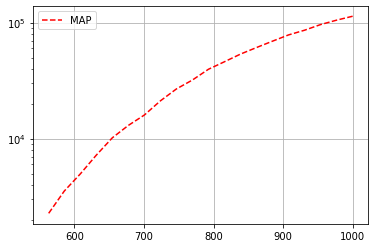

[[0.14223625]
 [0.13163125]
 [0.12056125]
 [0.10779   ]
 [0.0981775 ]
 [0.08673125]
 [0.07642   ]
 [0.06708625]
 [0.0576425 ]
 [0.04964875]
 [0.0401    ]
 [0.0335875 ]
 [0.02651   ]
 [0.02001625]
 [0.01628375]
 [0.012735  ]
 [0.00902625]
 [0.006215  ]
 [0.0044225 ]
 [0.00280875]]


In [191]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

# 1st step - calculate delta sum
delta_sum = []
for i in range(1,20):
    delta_sum.append(sigmas[i]-sigmas[i-1])
    #print(sigmas[i]-sigmas[i-1])
delta_sum = np.mean(delta_sum)
print(f'delta_sum = {delta_sum}')

# 2nd step - first new values for sigma
for i in range(0,20):
    print(f'i={i}\tsigmas[{i}]={sigmas[i]}')
new_sigmas = []
current = sigmas[-1]
for i in range(0,11):
    current += delta_sum
    new_sigmas.append(current)
    #print(f'i={i}\tnew_sigmas[{i}]={new_sigmas[i]}')

# 3rd step - calculate new delta sum
new_delta_sum = []
for i in range(1,11):
    new_delta_sum.append(new_sigmas[i]-new_sigmas[i-1])
    #print(new_sigmas[i]-new_sigmas[i-1])
new_delta_sum = np.mean(new_delta_sum)
print(f'new_delta_sum = {new_delta_sum}')

# 4th step - verify if delta sum and new delta sum are equal
assert np.abs(delta_sum - new_delta_sum) < 1e-12

# 5th step - obtain the polynomial regression for map ber
best_deg = 0
best_score = 0
sigmas_map = np.array(sigmas_map).reshape(20,1)
nb_errors_map = np.array(nb_errors_map).reshape(20,1)

reg_x = 1000*sigmas_map
print(f'reg_x = {reg_x}')
reg_y = nb_errors_map
print(f'reg_y = {reg_y}')

for deg in range(1,len(x_map)+1):
    polyreg = make_pipeline(PolynomialFeatures(deg),LinearRegression())
    polyreg.fit(reg_x,reg_y)
    score = polyreg.score(reg_x,reg_y)
    if score > best_score:
        best_deg = deg
        best_score = score
    print(f'deg = {deg}\tscore={score}')
print(f'best_deg = {best_deg}\tbest_score = {best_score}')

# 6th step - calculate the map ber for the new sigmas using the regression
print(f'sigmas = {sigmas}',type(sigmas))
print(f'sigmas_db = {10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N)}')
new_sigmas = np.array(new_sigmas)
print(f'new_sigmas = {new_sigmas}',type(new_sigmas))
print(f'new_sigmas_db = {10*np.log10(1/(2*new_sigmas**2)) - 10*np.log10(k/N)}')

polyreg = make_pipeline(PolynomialFeatures(best_deg),LinearRegression())
polyreg.fit(reg_x,reg_y)
y_tmp = []
for pred_x in new_sigmas:
    pred_y = reg.predict(np.array(pred_x).reshape(1,1))
    y_tmp.append(pred_y)
    print(f'pred_x={pred_x}\tpred_y={pred_y}')

plt.plot(reg_x, reg_y, label='MAP', linestyle='dashed', color='r')
#plt.plot(10*np.log10(1/(2*new_sigmas**2)) - 10*np.log10(k/N), np.array(y_tmp).reshape(11,1), label='MAP', linestyle='dashed', color='b')

#y_map = nb_errors_map/nb_bits_map

plt.grid()
plt.legend()
plt.yscale('log')
plt.show()
    
    
print(y_map)
    
# 7th step - plot map ber for sigmas (blue) new sigmas (red)

In [109]:
    
best_deg = 0
best_score = 0
for deg in range(1,len(x_map)+1):
    polyreg = make_pipeline(PolynomialFeatures(deg),LinearRegression())
    polyreg.fit(x_map,y_map)
    score = polyreg.score(x_map, y_map)
    if score > best_score:
        best_deg = deg
        best_score = score
    print(f'deg = {deg}\tscore={score}')
print(f'best_deg = {best_deg}\tbest_score = {best_score}')

SNR_dB_start_Eb = 5
SNR_dB_stop_Eb = 10
SNR_points = 20

SNR_dB_start_Es = SNR_dB_start_Eb + 10*np.log10(k/N)
SNR_dB_stop_Es = SNR_dB_stop_Eb + 10*np.log10(k/N)

sigma_start = np.sqrt(1/(2*10**(SNR_dB_start_Es/10)))
sigma_stop = np.sqrt(1/(2*10**(SNR_dB_stop_Es/10)))

new_sigmas = np.linspace(sigma_start, sigma_stop, SNR_points)
#new_sigmas = 10*np.log10(1/(2*new_sigmas**2)) - 10*np.log10(k/N)
print(sigmas)
print(new_sigmas)
print(sigmas[-1]-new_sigmas[0])

-0.02303466709524482
-0.02303466709524471
-0.02303466709524482
-0.02303466709524482
-0.02303466709524471
-0.02303466709524482
-0.02303466709524482
-0.02303466709524482
-0.02303466709524471
-0.02303466709524482
-0.02303466709524471
-0.02303466709524482
-0.02303466709524482
-0.02303466709524482
-0.02303466709524482
-0.02303466709524471
-0.02303466709524471
-0.02303466709524482
-0.02303466709524482
delta_sum = -0.023034667095244786
i=0	sigmas[0]=1.0
i=1	sigmas[1]=0.9769653329047552
i=2	sigmas[2]=0.9539306658095105
i=3	sigmas[3]=0.9308959987142656
i=4	sigmas[4]=0.9078613316190208
i=5	sigmas[5]=0.8848266645237761
i=6	sigmas[6]=0.8617919974285313
i=7	sigmas[7]=0.8387573303332865
i=8	sigmas[8]=0.8157226632380417
i=9	sigmas[9]=0.792687996142797
i=10	sigmas[10]=0.7696533290475521
i=11	sigmas[11]=0.7466186619523074
i=12	sigmas[12]=0.7235839948570626
i=13	sigmas[13]=0.7005493277618178
i=14	sigmas[14]=0.677514660666573
i=15	sigmas[15]=0.6544799935713281
i=16	sigmas[16]=0.6314453264760834
i=17	sigm